In [517]:
import numpy as np 
import pandas as pd
import copy
import pickle
import joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler as under_sam

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

### ICFS function
Takes a dataframe as parameter and saves to file all the features necessary to describe DoS+Probe and U2R+R2L

In [518]:
def pearson_correlated_features(x, y, threshold):
    y['target'] = y['target'].astype(int)

    for p in x.columns:
        x[p] = x[p].astype(float)

    # Ensure y is a DataFrame for consistency
    if isinstance(y, pd.Series):
        y = pd.DataFrame(y, columns=['target'])

    # Calculate the Pearson's correlation coefficients between features and the target variable(s)
    corr_matrix = x.corrwith(y['target'])

    # Select features with correlations above the threshold
    selected_features = x.columns[corr_matrix.abs() > threshold].tolist()

    return selected_features

In [519]:
def compute_set_difference(df1, df2):
    # Create a new DataFrame containing the set difference of the two DataFrames.
    df_diff = df1[~df1.index.isin(df2.index)]
    # Return the DataFrame.
    return df_diff

In [520]:
def perform_icfs(x_train):
    # now ICFS only on the numerical features
    num_train = copy.deepcopy(x_train)
    del num_train['protocol_type']
    del num_train['service']
    del num_train['flag']

    target = pd.DataFrame()
    target['target'] = np.array([1 if x != 'normal' else 0 for x in num_train['label']])
    num_train = pd.concat([num_train, target], axis=1)

    # These are how attacks are categorized in the trainset
    dos_list = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
    probe_list = ['ipsweep', 'portsweep', 'satan', 'nmap']
    u2r_list = ['loadmodule', 'perl', 'rootkit', 'buffer_overflow']
    r2l_list = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']
    normal = ['normal']

    # useful sub-sets
    x_normal = num_train[num_train['label'].isin(normal)]
    x_u2r = num_train[num_train['label'].isin(u2r_list)]
    x_r2l = num_train[num_train['label'].isin(r2l_list)]
    x_dos = num_train[num_train['label'].isin(dos_list)]
    x_probe = num_train[num_train['label'].isin(probe_list)]

    # start the ICFS with l1

    # features for dos
    dos = copy.deepcopy(num_train)
    del dos['target']
    y = np.array([1 if x in dos_list else 0 for x in dos['label']])
    y_dos = pd.DataFrame(y, columns=['target'])
    del dos['label']
    dos_all = pearson_correlated_features(dos, y_dos, 0.1)
    print(dos_all)

    # features for probe
    probe = copy.deepcopy(num_train)
    del probe['target']
    y = np.array([1 if x in probe_list else 0 for x in probe['label']])
    y_probe = pd.DataFrame(y, columns=['target'])
    del probe['label']
    probe_all = pearson_correlated_features(probe, y_probe, 0.1)
    print(probe_all)

    # intersect for the optimal features
    set_dos = set(dos_all)
    set_probe = set(probe_all)

    comm_features_l1 = set_probe & set_dos

    print('common features to train l1: ', comm_features_l1)

    # now l2 needs the features to describe the difference between rare attacks and normal traffic

    # features for u2r
    u2r = pd.concat([x_u2r, x_normal], axis=0)
    del u2r['target']
    y = np.array([1 if x in u2r_list else 0 for x in u2r['label']])
    y_u2r = pd.DataFrame(y, columns=['target'])
    del u2r['label']
    u2r_all = pearson_correlated_features(u2r, y_u2r, 0.01)
    print(u2r_all)

    # features for r2l
    r2l = pd.concat([x_r2l, x_normal], axis=0)
    del r2l['target']
    y = np.array([1 if x in r2l_list else 0 for x in r2l['label']])
    y_r2l = pd.DataFrame(y, columns=['target'])
    del r2l['label']
    r2l_all = pearson_correlated_features(r2l, y_r2l, 0.01)
    print(r2l_all)

    # intersect for the optimal features
    set_r2l = set(r2l_all)
    set_u2r = set(u2r_all)

    comm_features_l2 = set_r2l & set_u2r
    # print('Common features to train l2: ', len(common_features_l2), common_features_l2)

    with open('NSL-KDD Files/NSL_features_l1.txt', 'w') as g:
        for a, x in enumerate(comm_features_l1):
            if a < len(comm_features_l1) - 1:
                g.write(x + ',' + '\n')
            else:
                g.write(x)

    # read the common features from file
    with open('NSL-KDD Files/NSL_features_l2.txt', 'w') as g:
        for a, x in enumerate(comm_features_l2):
            if a < len(comm_features_l2) - 1:
                g.write(x + ',' + '\n')
            else:
                g.write(x)

# Main implementation

In [521]:
# loading the train 20% set
"""
df_train20 = pd.read_csv('EvalResources/KDDTrain+20_percent_with_labels.txt', sep=",", header=None)
df_train20 = df_train20[df_train20.columns[:-1]]  # tags column
titles = pd.read_csv('KB Process/NSL-KDD Original Datasets/Field Names.csv', header=None)
label = pd.Series(['label'], index=[41])
titles = pd.concat([titles[0], label])
df_train20.columns = titles.to_list()
df_train20 = df_train20.drop(['num_outbound_cmds'],axis=1)
df_train_original = df_train20

# df_train_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTrain+20_percent_with_labels.txt', index=False)

df_train_original
"""

'\ndf_train20 = pd.read_csv(\'EvalResources/KDDTrain+20_percent_with_labels.txt\', sep=",", header=None)\ndf_train20 = df_train20[df_train20.columns[:-1]]  # tags column\ntitles = pd.read_csv(\'KB Process/NSL-KDD Original Datasets/Field Names.csv\', header=None)\nlabel = pd.Series([\'label\'], index=[41])\ntitles = pd.concat([titles[0], label])\ndf_train20.columns = titles.to_list()\ndf_train20 = df_train20.drop([\'num_outbound_cmds\'],axis=1)\ndf_train_original = df_train20\n\n# df_train_original.to_csv(\'KB Process/NSL-KDD Original Datasets/KDDTrain+20_percent_with_labels.txt\', index=False)\n\ndf_train_original\n'

In [522]:
# loading the train set
df_train = pd.read_csv('EvalResources/KDDTrain+.txt', sep=",", header=None)
df_train = df_train[df_train.columns[:-1]]  # tags column
titles = pd.read_csv('EvalResources/Field Names.csv', header=None)
label = pd.Series(['label'], index=[41])
titles = pd.concat([titles[0], label])
df_train.columns = titles.to_list()
df_train = df_train.drop(['num_outbound_cmds'],axis=1)
df_train_original = df_train

# df_train_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTrain+_with_labels.txt', index=False)

#df_train_original

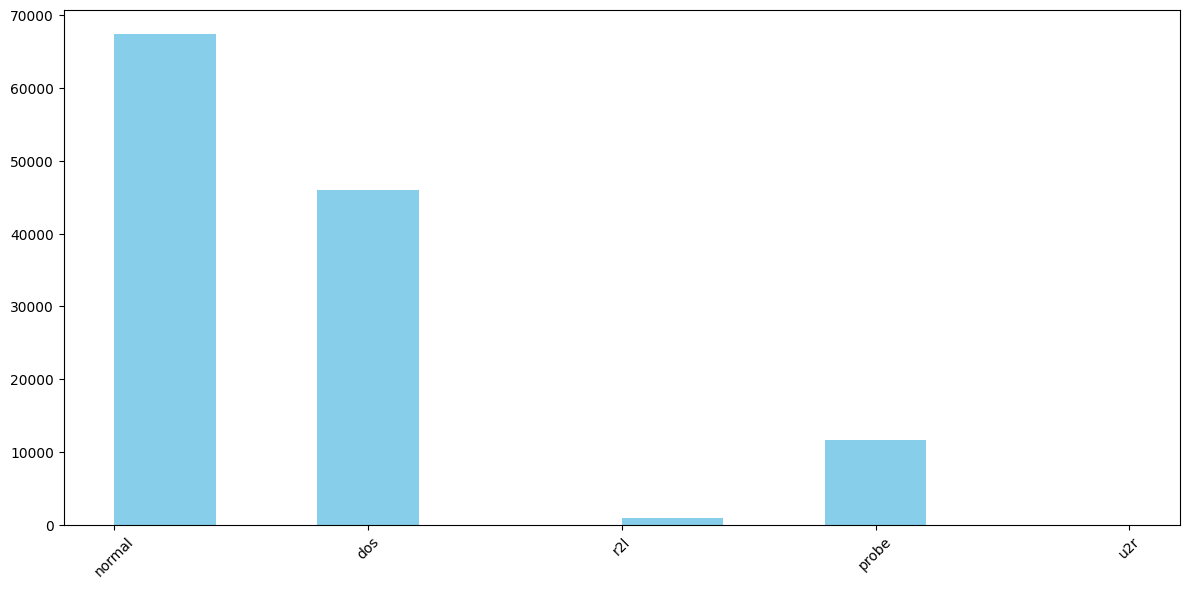

In [523]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# EDA Plots of the whole dataset

data = copy.deepcopy(df_train_original)

# Separate features and labels
features = data.drop('label', axis=1)
labels = data['label']

# Build the major category attacks array
attacks = []
for item in labels:
    if item in ["back", "land", "neptune", "pod", "smurf", "teardrop"]:
        attacks.append("dos")
    elif item in ["ipsweep", "nmap", "portsweep", "satan"]:
        attacks.append("probe")
    elif item in ["ftp_write", "guess_passwd", "imap", "multihop", "phf", "spy", "warezmaster", "warezclient"]:
        attacks.append("r2l")
    elif item in ["buffer_overflow", "loadmodule", "perl", "rootkit"]:
        attacks.append("u2r")
    else: 
        attacks.append("normal")
        
# Plot histograms
df_hist = copy.deepcopy(features)
df_hist['attack_cat'] = attacks
df_hist['labels'] = labels

plt.figure(figsize=(12, 6))
plt.hist(df_hist['attack_cat'], bins=10, color='skyblue', align='mid')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('')
plt.title('')
plt.savefig('Attacks histogram')
#plt.show()

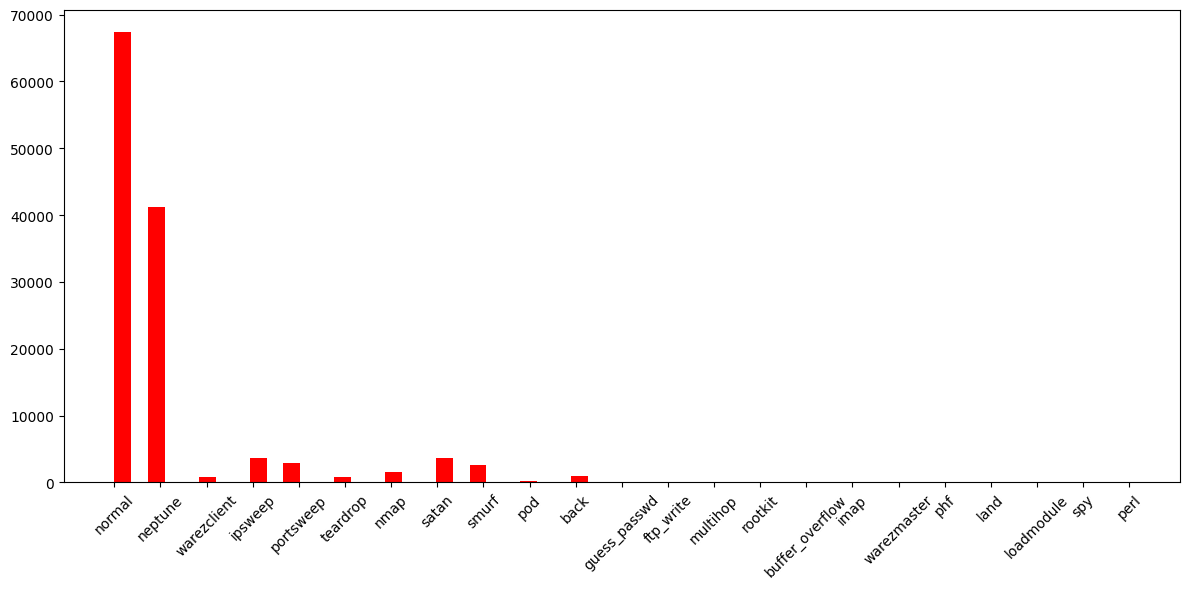

In [524]:
# Plot histograms
df_hist = copy.deepcopy(features)
df_hist['attack_cat'] = attacks
df_hist['labels'] = labels

plt.figure(figsize=(12, 6))
plt.hist(df_hist['labels'], bins=60, color='red', align='mid')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('')
plt.title('')
plt.savefig('Sub-attacks histogram')
#plt.show()

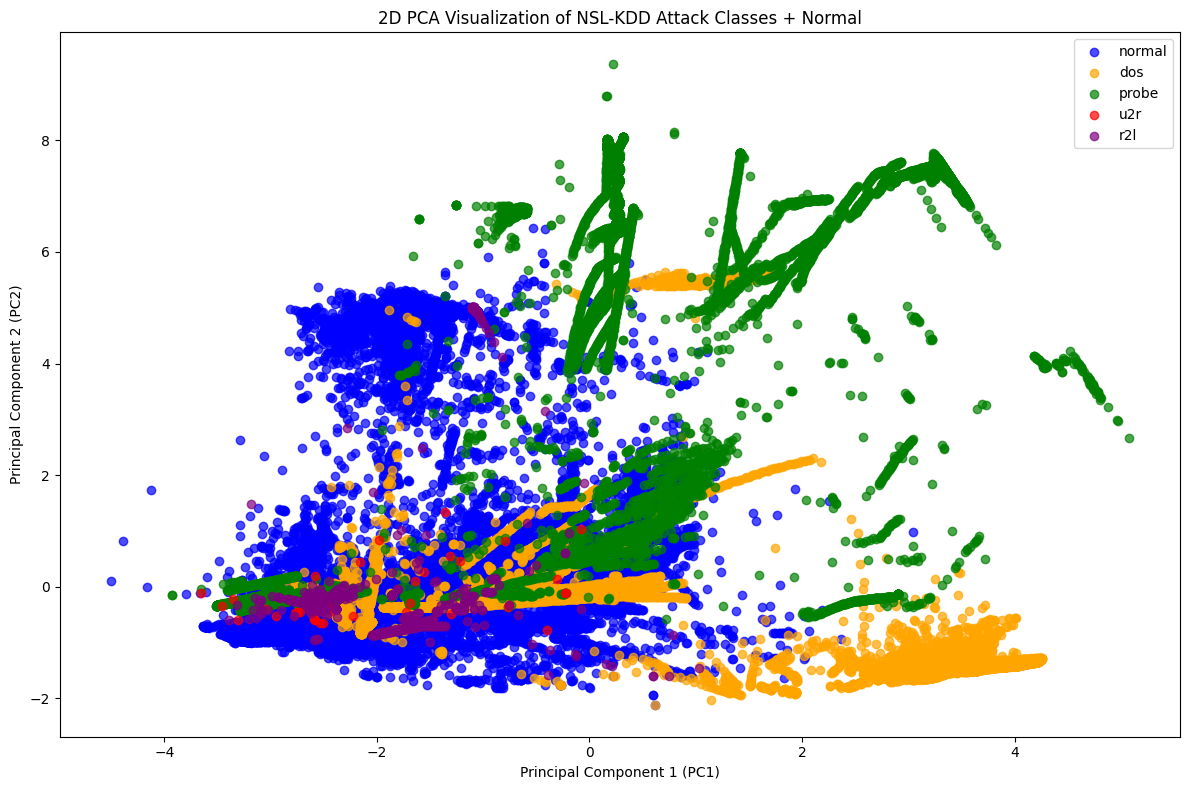

In [525]:
# Drop the categorical features
del features['flag']
del features['protocol_type']
del features['service']

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['label'] = labels
pca_df['attacks'] = attacks

# Plot the 2D PCA visualization
plt.figure(figsize=(12, 8))
colors = {'normal': 'blue', 'dos': 'orange', 'probe': 'green', 'u2r': 'red', 'r2l': 'purple'}

for attack_class, color in colors.items():
    subset = pca_df[pca_df['attacks'] == attack_class]
    plt.scatter(subset['PC1'], subset['PC2'], label=attack_class, color=color, alpha=0.7)

plt.title('2D PCA Visualization of NSL-KDD Attack Classes + Normal')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.tight_layout()
plt.legend()
plt.savefig('PCA Visualization')
#plt.show()

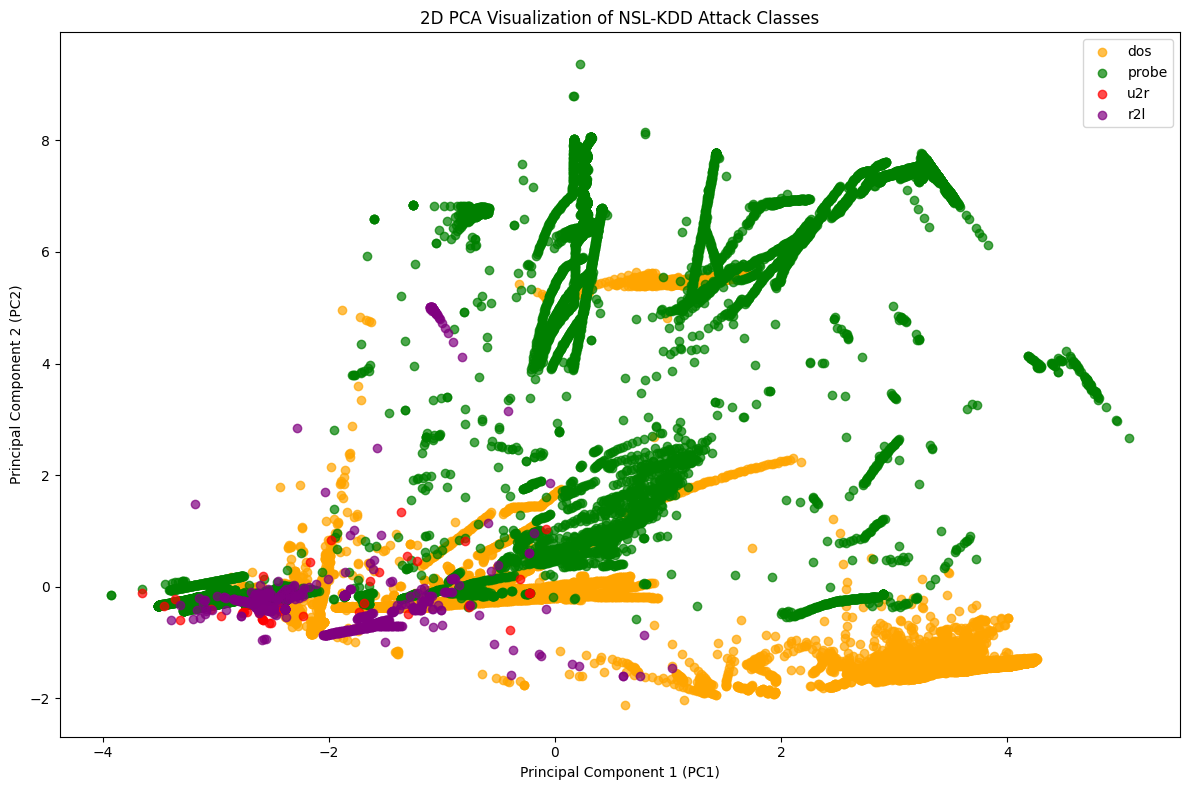

In [526]:
# Same plot without normal instances
plt.figure(figsize=(12, 8))
colors = {'dos': 'orange', 'probe': 'green', 'u2r': 'red', 'r2l': 'purple'}

for attack_class, color in colors.items():
    subset = pca_df[pca_df['attacks'] == attack_class]
    plt.scatter(subset['PC1'], subset['PC2'], label=attack_class, color=color, alpha=0.7)

plt.title('2D PCA Visualization of NSL-KDD Attack Classes')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.tight_layout()
plt.legend()
plt.savefig('PCA Visualization no normal')
#plt.show()

In [527]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None)
df_test_ = df_test.sort_index(axis=1)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test

# df_test_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTest+.txt', index=False)

#df_test_original

### Execution Parameters

In [528]:
EXPORT_MODELS = 0
EXPORT_DATASETS = 0
EXPORT_PCA = 0
EXPORT_ENCODERS = 0

pd.options.display.max_columns = None

In [529]:
# list of single attacks 
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'worm', 'apache2', 'mailbomb', 'processtable', 'udpstorm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
r2l_attacks = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop']
u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] 

# list of attack classes split according to detection layer
dos_probe_list = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'ipsweep', 'nmap', 'portsweep', 'satan']
dos_probe_test = ['apache2', 'mailbomb', 'processtable', 'udpstorm', 'mscan', 'saint']
u2r_r2l_list = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'buffer_overflow', 'loadmodule', 'rootkit', 'perl']
u2r_r2l_test = ['httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop', 'ps', 'xterm', 'sqlattack']
normal_list = ['normal']
categorical_features = ['protocol_type', 'service', 'flag']

In [530]:
# load the features obtained with ICFS for both layer 1 and layer 2
with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l1.txt', 'r') as f:
    common_features_l1 = f.read().split(',')

with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l2.txt', 'r') as f:
    common_features_l2 = f.read().split(',')

In [531]:
df_train_and_validate = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

In [532]:
# Save all the targets for the dataset

y_test_l1 = [1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test['label']]
y_test_l2 = [1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_test['label']]

if EXPORT_DATASETS:
    np.save("EvalResources/AdditionalSets/l1_full_test_targets.npy", y_test_l1)
    np.save("EvalResources/AdditionalSets/l2_full_test_targets.npy", y_test_l2)

# DOS PROBE CLASSIFIER

In [533]:
# split in test and validation set for BOTH layers
df_train_original, df_val_original = train_test_split(df_train_and_validate, test_size=0.2, random_state=42)

# dataframes specifically for layer 1
df_train = copy.deepcopy(df_train_original)
df_val = copy.deepcopy(df_val_original)

# set the target variables accordingly
y_train = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_train['label']])
y_val = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_val['label']])

# this dataframe contains the whole train set 
df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,214,14939,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16,18,0.0,0.0,0.0,0.0,1.00,0.00,0.17,52,255,1.00,0.00,0.02,0.06,0.0,0.0,0.0,0.0
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,2,1.0,1.0,0.0,0.0,0.01,0.06,0.00,255,2,0.01,0.06,0.00,0.00,1.0,1.0,0.0,0.0
2,0,tcp,http,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,273,8,0.0,0.0,1.0,1.0,0.03,0.06,0.00,255,8,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0
3,0,tcp,http,SF,257,259,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,20,20,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,0,udp,other,SF,516,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,274,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100773,0,tcp,echo,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258,4,0.0,0.0,1.0,1.0,0.02,0.07,0.00,255,4,0.02,0.09,0.00,0.00,0.0,0.0,1.0,1.0
100774,0,tcp,telnet,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,4,1.0,1.0,0.0,0.0,0.17,0.08,0.00,255,4,0.02,0.07,0.01,0.00,1.0,1.0,0.0,0.0
100775,0,tcp,http,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258,6,0.0,0.0,1.0,1.0,0.02,0.07,0.00,255,6,0.02,0.07,0.00,0.00,0.0,0.0,1.0,1.0
100776,0,tcp,http,SF,309,4281,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.00,0.00,0.00,21,255,1.00,0.00,0.05,0.05,0.0,0.0,0.0,0.0


In [534]:
# this dataframe contains the whole validation set
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)

#df_val

In [535]:
# now the real processing for layer 1 starts
X_train = df_train[common_features_l1]
#X_train

In [536]:
X_validate = df_val[common_features_l1]
#X_validate

In [537]:
# 2 one-hot encoders, one for the features of layer1 and one for the features of layer2
ohe = OneHotEncoder(handle_unknown='ignore')
ohe2 = OneHotEncoder(handle_unknown='ignore')
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

In [538]:
# scaling the train set for layer1
df_minmax = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)

#X_train

In [539]:
# scaling the validation set for layer1
df_minmax_val = scaler1.transform(X_validate)
X_validate = pd.DataFrame(df_minmax_val, columns=X_validate.columns)

#X_validate

In [540]:
# perform One-hot encoding for the train set
label_enc = ohe.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)

df_train.iloc[:,1:4]

,protocol_type,service,flag
0,tcp,http,SF
1,tcp,private,S0
2,tcp,http,REJ
3,tcp,http,SF
4,udp,other,SF
...,...,...,...
100773,tcp,echo,RSTO
100774,tcp,telnet,S0
100775,tcp,http,REJ
100776,tcp,http,SF


In [541]:
# perform One-hot encoding for the validation set
label_enc = ohe.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)

#X_validate

In [542]:
#X_train

In [543]:
#X_validate

In [544]:
# do the same for test set
y_test = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test['label']])

df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

In [545]:
X_test = df_test[common_features_l1]

#X_test

In [546]:
df_minmax = scaler1.transform(X_test)
X_test = pd.DataFrame(df_minmax, columns=X_test.columns)
#X_test

In [547]:
label_enc = ohe.transform(df_test.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)
#X_test

In [548]:
print('Shape of the whole train set: ', X_train.shape)
print('Shape of its targets: ', y_train.shape)
print('Shape of the whole test set: ', X_test.shape)
print('Shape of its targets: ', y_test.shape)

Shape of the whole train set:  (100778, 101)
Shape of its targets:  (100778,)
Shape of the whole test set:  (22544, 101)
Shape of its targets:  (22544,)


In [549]:
# Export the dataset for training layer 1
if EXPORT_DATASETS:
    """
    X_train.to_csv('EvalResources/ProcessedDatasets/x_train_l1.txt', index=False)
    X_validate.to_csv('EvalResources/ProcessedDatasets/x_val_l1.txt', index=False)
    """
    np.save('EvalResources/ProcessedWithPCA/y_train_l1', y_train)
    np.save('EvalResources/ProcessedWithPCA/y_val_l1', y_val)
    np.save('EvalResources/ProcessedWithPCA/y_test_l1', y_test)

### Principal Component Analysis

In [550]:
pca_dos_probe = PCA(n_components=0.95)
X_train_dos_probe = pca_dos_probe.fit_transform(X_train)
X_test_dos_probe = pca_dos_probe.transform(X_test)
X_validate_dos_probe = pca_dos_probe.transform(X_validate)

# X_train = X_train.sort_index(axis=1)
X_train_dos_probe.shape

(100778, 28)

In [551]:
if EXPORT_PCA:
    # save the pca transformed as well as the transformer
    column_names = [f'PC{i}' for i in range(1, X_test_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_test_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_test_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_train_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_train_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_train_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_validate_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_validate_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_val_l1_pca.txt', index=False)

    joblib.dump(pca_dos_probe, 'EvalResources/Encoders/pca_transformer_l1.pkl')

### Building the classifier for the layer1

In [552]:
from datetime import datetime

# Using Random Forest Classifier
dos_probe_classifier = RandomForestClassifier()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

In [553]:
from sklearn.neighbors import KNeighborsClassifier

# Using KNN
dos_probe_classifier = KNeighborsClassifier()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

Metrics for layer 1:
Confusion matrix: [TP FN / FP TN]
 [[11958   705]
 [ 1850  8031]]
Accuracy =  0.88666607523066
F1 Score =  0.8627598431541064
Precision =  0.9192994505494505
Recall =  0.8127719866410282
Train time =  0:00:00.026749
Shape of the train set for l1:  (100778, 28)


from sklearn.ensemble import HistGradientBoostingClassifier

# Using HistGradientBoosting classifier
dos_probe_classifier = HistGradientBoostingClassifier(learning_rate=1, l2_regularization=0)

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# Using SVC
dos_probe_classifier = SVC()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# Using the Naive Bayes Classifier
dos_probe_classifier = GaussianNB()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# R2L+U2R classifier

In [554]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)
df_val = copy.deepcopy(df_val_original)

# load targeted attacks (Normal + r2l + u2r)
df_train = df_train[df_train['label'].isin(normal_list+u2r_attacks+r2l_attacks)]
df_val = df_val[df_val['label'].isin(normal_list+u2r_attacks+r2l_attacks)]

# set the target variables accordingly
y_train = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_train['label']])
y_val = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_val['label']])

df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
#df_train

In [555]:
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)
#df_val

In [556]:
X_train = df_train[common_features_l2]
#X_train

In [557]:
X_validate = df_val[common_features_l2]
#X_validate

In [558]:
df_minmax = scaler2.fit_transform(X_train)
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)
#X_train

In [559]:
df_minmax = scaler2.transform(X_validate)
X_validate = pd.DataFrame(df_minmax, columns=X_validate.columns)
#X_validate

In [560]:
# perform One-hot encoding for the train set
label_enc = ohe2.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)
#X_train

In [561]:
# perform One-hot encoding for the validation set
label_enc = ohe2.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)
#X_validate

In [562]:
# do the same for test set
df_test = df_test[df_test['label'].isin(normal_list+u2r_attacks+r2l_attacks)]

y_test = np.array([0 if x=='normal' else 1 for x in df_test['label']])
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

In [563]:
y_test.shape

(12663,)

In [564]:
X_test = df_test[common_features_l2] 
#X_test

In [565]:
df_minmax = scaler2.transform(X_test)
X_test = pd.DataFrame(df_minmax, columns=X_test.columns)
#X_test

In [566]:
label_enc = ohe2.transform(df_test.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)
#X_test

In [567]:
print('Shape of the train set: ', X_train.shape)
print('Shape of its target: ', y_train.shape)
print('Shape of the test set: ', X_test.shape)
print('Shape of its target: ', y_test.shape)

Shape of the train set:  (54733, 51)
Shape of its target:  (54733,)
Shape of the test set:  (12663, 51)
Shape of its target:  (12663,)


In [568]:
# Under sampling the train set for l2
sm = under_sam(sampling_strategy=1)
X_train, y_train = sm.fit_resample(X_train,y_train)

# Now let's compute the class weights
class_counts = {0: len(y_train[y_train==0]), 1: len(y_train[y_train==1])}

total_samples = sum(class_counts.values())
class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}

## Export the datasets
Train set has been scaled, one hot encoded, undersampled
Test set has been scaled and one hot encoded

In [569]:
# Export the dataset for training layer 2
if EXPORT_DATASETS:
    # X_train.to_csv('EvalResources/ProcessedDatasets/x_train_l2.txt', index=False)
    np.save('EvalResources/ProcessedWithPCA/y_train_l2', y_train)
    # X_validate.to_csv('EvalResources/ProcessedDatasets/x_val_l2.txt', index=False)
    np.save('EvalResources/ProcessedWithPCA/y_val_l2', y_val)
    np.save('EvalResources/ProcessedWithPCA/y_test_l2', y_test)

In [570]:
# Principal Component Analysis
pca_r2l_u2r = PCA(n_components=0.95)
X_train_r2l_u2r = pca_r2l_u2r.fit_transform(X_train)
X_test_r2l_u2r = pca_r2l_u2r.transform(X_test)
X_validate_r2l_u2r = pca_r2l_u2r.transform(X_validate)

In [571]:
# Support Vector Machine for layer l2
r2l_u2r_classifier = SVC(C=0.1, gamma=0.01, kernel='rbf', probability=True)

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train)
ttime = datetime.now() - start

predicted = r2l_u2r_classifier.predict(X_test_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Matthew corr = ', matthews_corrcoef(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the training set: ', X_train_r2l_u2r.shape)

Metrics for layer 2:
Confusion matrix: [TP FN / FP TN]
 [[9075  636]
 [1532 1420]]
Accuracy =  0.8287925452104556
F1 Score =  0.5670926517571886
Precision =  0.6906614785992218
Recall =  0.481029810298103
Matthew corr =  0.47642230653164025
Train time =  0:00:00.468048
Shape of the training set:  (1624, 13)


In [572]:
predicted = r2l_u2r_classifier.predict(X_train_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_train,predicted))
print('Accuracy = ', accuracy_score(y_train,predicted))
print('F1 Score = ', f1_score(y_train,predicted))
print('Precision = ', precision_score(y_train,predicted))
print('Recall = ', recall_score(y_train,predicted))
print('Matthew corr = ', matthews_corrcoef(y_train,predicted))
print('Train time = ', ttime)

Metrics for layer 2:
Confusion matrix: [TP FN / FP TN]
 [[696 116]
 [  4 808]]
Accuracy =  0.9261083743842364
F1 Score =  0.9308755760368664
Precision =  0.8744588744588745
Recall =  0.9950738916256158
Matthew corr =  0.8604409851524493
Train time =  0:00:00.468048


r2l_u2r_classifier = GaussianNB()

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train)
ttime = datetime.now() - start

predicted = r2l_u2r_classifier.predict(X_test_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Matthew corr = ', matthews_corrcoef(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the training set: ', X_train_r2l_u2r.shape)

predicted = r2l_u2r_classifier.predict(X_train_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_train,predicted))
print('Accuracy = ', accuracy_score(y_train,predicted))
print('F1 Score = ', f1_score(y_train,predicted))
print('Precision = ', precision_score(y_train,predicted))
print('Recall = ', recall_score(y_train,predicted))
print('Matthew corr = ', matthews_corrcoef(y_train,predicted))
print('Train time = ', ttime)

from sklearn import tree

r2l_u2r_classifier = tree.DecisionTreeClassifier()

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train)
ttime = datetime.now() - start

predicted = r2l_u2r_classifier.predict(X_test_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Matthew corr = ', matthews_corrcoef(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the training set: ', X_train_r2l_u2r.shape)

predicted = r2l_u2r_classifier.predict(X_train_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_train,predicted))
print('Accuracy = ', accuracy_score(y_train,predicted))
print('F1 Score = ', f1_score(y_train,predicted))
print('Precision = ', precision_score(y_train,predicted))
print('Recall = ', recall_score(y_train,predicted))
print('Matthew corr = ', matthews_corrcoef(y_train,predicted))
print('Train time = ', ttime)

from sklearn.ensemble import GradientBoostingClassifier

r2l_u2r_classifier = GradientBoostingClassifier()

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train)
ttime = datetime.now() - start

predicted = r2l_u2r_classifier.predict(X_test_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Matthew corr = ', matthews_corrcoef(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the training set: ', X_train_r2l_u2r.shape)

predicted = r2l_u2r_classifier.predict(X_train_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_train,predicted))
print('Accuracy = ', accuracy_score(y_train,predicted))
print('F1 Score = ', f1_score(y_train,predicted))
print('Precision = ', precision_score(y_train,predicted))
print('Recall = ', recall_score(y_train,predicted))
print('Matthew corr = ', matthews_corrcoef(y_train,predicted))
print('Train time = ', ttime)

In [573]:
if EXPORT_PCA:
        # save the pca transformed as well as the transformer
    column_names = [f'PC{i}' for i in range(1, X_test_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_test_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_test_l2_pca.txt', index=False)
        
    print(x.shape)
    
    column_names = [f'PC{i}' for i in range(1, X_train_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_train_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_train_l2_pca.txt', index=False)
        
    print(x.shape)
    
    column_names = [f'PC{i}' for i in range(1, X_validate_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_validate_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedWithPCA/x_val_l2_pca.txt', index=False)
        
    print(x.shape)
        
    joblib.dump(pca_r2l_u2r, 'EvalResources/ProcessedWithPCA/pca_transformer_l2.pkl')

### Export the classifiers

In [574]:
if EXPORT_MODELS:
    with open('EvalResources/StartingModels/l1_classifier.pkl', "wb") as f:
        pickle.dump(dos_probe_classifier, f)
    with open('EvalResources/StartingModels/l2_classifier.pkl', "wb") as f:
        pickle.dump(r2l_u2r_classifier, f)

In [575]:
# Export one hot encoders
if EXPORT_ENCODERS:
    joblib.dump(ohe, 'EvalResources/Encoders/ohe_l1.pkl')
    joblib.dump(ohe2, 'EvalResources/Encoders/ohe_l2.pkl')
    joblib.dump(scaler1, 'EvalResources/Encoders/scaler_l1.pkl')
    joblib.dump(scaler2, 'EvalResources/Encoders/scaler_l2.pkl')

# Testing

In [576]:
df_test1 = copy.deepcopy(df_test_original)
df_test2 = copy.deepcopy(df_test_original)
y_test_real = np.array([0 if x=='normal' else 1 for x in df_test1['label']])

In [577]:
y_test_real.shape

(22544,)

In [578]:
X_test1 = df_test1[common_features_l1]
#X_test1

In [579]:
df_minmax = scaler1.transform(X_test1)
X_test1 = pd.DataFrame(df_minmax, columns=X_test1.columns)
label_enc = ohe.transform(df_test1.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test1 = pd.concat([X_test1, df_enc], axis=1)

X_test_layer1 = pca_dos_probe.transform(X_test1)
print('Test set shape for layer 1: ', X_test_layer1.shape)

Test set shape for layer 1:  (22544, 28)


In [580]:
#X_test1

In [581]:
X_test2 = df_test2[common_features_l2] 
#X_test2

In [582]:
df_minmax = scaler2.transform(X_test2)
X_test2 = pd.DataFrame(df_minmax, columns=X_test2.columns)
label_enc = ohe2.transform(df_test2.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test2 = pd.concat([X_test2, df_enc], axis=1)

X_test_layer2 = pca_r2l_u2r.transform(X_test2)
print('Test set shape for layer 1: ', X_test_layer1.shape)
print('Test set shape for layer 2: ', X_test_layer2.shape)

Test set shape for layer 1:  (22544, 28)
Test set shape for layer 2:  (22544, 13)


In [583]:
#X_test_layer1

In [584]:
#X_test_layer2

In [585]:
# same classifiers obtained above
classifier1 = dos_probe_classifier
classifier2 = r2l_u2r_classifier

In [586]:
# test the other classifiers obtained in the evaluation phase
#classifier1 = joblib.load("EvalResources/Models/l1_clf.pkl")
#classifier2 = joblib.load("EvalResources/Models/l2_clf.pkl")

In [587]:
import warnings

# Suppressing the warning
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

result = []
for i in range(X_test_layer2.shape[0]):
    layer1 = classifier1.predict(X_test_layer1[i].reshape(1, -1))[0]
    if layer1 == 1:
        result.append(layer1)
    else:
        layer2 = classifier2.predict(X_test_layer2[i].reshape(1, -1))[0]
        if layer2 == 1:
            result.append(layer2)
        else:
            result.append(0)
            
result = np.array(result)

In [588]:
# the results may vary
# C=0.1, gamma=0.01
print('Results for the layer 2 (SVM):')
print(confusion_matrix(y_test_real,result))
print('Accuracy = ', accuracy_score(y_test_real,result))
print('F1 Score = ', f1_score(y_test_real,result))
print('Precision = ', precision_score(y_test_real,result))
print('Recall = ', recall_score(y_test_real,result))
print('Matthew corr = ', matthews_corrcoef(y_test_real,result))

Results for the layer 2 (SVM):
[[8460 1251]
 [3098 9735]]
Accuracy =  0.8070883605393896
F1 Score =  0.8174146689617532
Precision =  0.8861277990169306
Recall =  0.758591132237201
Matthew corr =  0.6239009158877384


In [589]:
result = []
TP = FP = TN = FN = 0

for i in range(X_test_layer2.shape[0]):
    layer1 = classifier1.predict(X_test_layer1[i].reshape(1, -1))[0]
    if layer1 == 1:
        result.append(layer1)
        if y_test_real[i] == 1:
            TP += 1
        else:
            FP += 1
    else:
        layer2 = classifier2.predict(X_test_layer2[i].reshape(1, -1))[0]
        if layer2 == 1:
            result.append(layer2)
            if y_test_real[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            result.append(0)
            if y_test_real[i] == 0:
                TN += 1
            else:
                FN += 1

result = np.array(result)

# Compute TPR, FPR, TNR, FNR
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
FNR = FN / (FN + TP)

# Print TPR, FPR, TNR, FNR
print('True Positive Rate (TPR) =', TPR)
print('False Positive Rate (FPR) =', FPR)
print('True Negative Rate (TNR) =', TNR)
print('False Negative Rate (FNR) =', FNR)

True Positive Rate (TPR) = 0.758591132237201
False Positive Rate (FPR) = 0.12882298424467098
True Negative Rate (TNR) = 0.871177015755329
False Negative Rate (FNR) = 0.24140886776279905


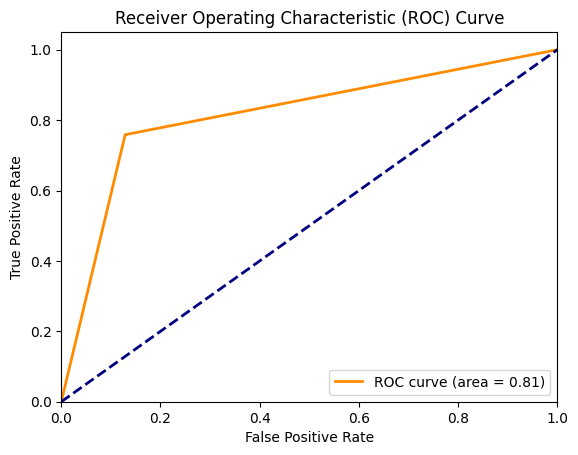

In [590]:
# ROC graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_real, result)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('static_roc_curve.png')

plt.show()

### Export the test sets

In [591]:
"""
if True:
    column_names = [f'PC{i}' for i in range(1, X_test_layer1.shape[1] + 1)]
    X1_test = pd.DataFrame(data=X_test_layer1, columns=column_names)
    X1_test.to_csv('EvalResources/AdditionalSets/x_test_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_test_layer2.shape[1] + 1)]
    X2_test = pd.DataFrame(data=X_test_layer2, columns=column_names)
    X2_test.to_csv('EvalResources/AdditionalSets/x_test_l2_pca.txt', index=False)
    
    np.save('EvalResources/AdditionalSets/y_test', y_test_real)
"""


"\nif True:\n    column_names = [f'PC{i}' for i in range(1, X_test_layer1.shape[1] + 1)]\n    X1_test = pd.DataFrame(data=X_test_layer1, columns=column_names)\n    X1_test.to_csv('EvalResources/AdditionalSets/x_test_l1_pca.txt', index=False)\n    \n    column_names = [f'PC{i}' for i in range(1, X_test_layer2.shape[1] + 1)]\n    X2_test = pd.DataFrame(data=X_test_layer2, columns=column_names)\n    X2_test.to_csv('EvalResources/AdditionalSets/x_test_l2_pca.txt', index=False)\n    \n    np.save('EvalResources/AdditionalSets/y_test', y_test_real)\n"

### evaluate seen and unseen attack categories

In [592]:
# load testset
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)

df_test_original = df_test

In [593]:
if EXPORT_DATASETS:
    df_test_original.to_csv('EvalResources/ProcessedDatasets/x_test_full.txt', index=False)
    np.save('EvalResources/ProcessedDatasets/y_test_full', y_test)
    
df_test_original

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal


In [594]:
new_attack = []
for i in df_test_original['label'].value_counts().index.tolist()[1:]:
    if i not in df_train_original['label'].value_counts().index.tolist()[1:]:
        new_attack.append(i)
        
new_attack.sort()
new_attack

['apache2',
 'httptunnel',
 'mailbomb',
 'mscan',
 'named',
 'processtable',
 'ps',
 'saint',
 'sendmail',
 'snmpgetattack',
 'snmpguess',
 'sqlattack',
 'udpstorm',
 'worm',
 'xlock',
 'xsnoop',
 'xterm']

In [595]:
index_of_new_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] in new_attack:
        index_of_new_attacks.append(df_test_original.index[i])

In [596]:
len(index_of_new_attacks)

3750

In [597]:
new_attack.append('normal')
new_attack

['apache2',
 'httptunnel',
 'mailbomb',
 'mscan',
 'named',
 'processtable',
 'ps',
 'saint',
 'sendmail',
 'snmpgetattack',
 'snmpguess',
 'sqlattack',
 'udpstorm',
 'worm',
 'xlock',
 'xsnoop',
 'xterm',
 'normal']

In [598]:
index_of_old_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] not in new_attack:
        index_of_old_attacks.append(df_test_original.index[i])

In [599]:
len(index_of_old_attacks)

9083

In [600]:
print('Number of new attacks in the test set: ', result[index_of_new_attacks].shape[0])
print('Number of new attacks detected by the classifiers: ', result[index_of_new_attacks].sum())
print('Proportion of new attacks detected: ', result[index_of_new_attacks].sum()/result[index_of_new_attacks].shape[0])

Number of new attacks in the test set:  3750
Number of new attacks detected by the classifiers:  1924
Proportion of new attacks detected:  0.5130666666666667


In [601]:
print('Number of old attacks in the test set: ', result[index_of_old_attacks].shape[0])
print('Number of old attacks detected by the classifiers: ', result[index_of_old_attacks].sum())
print('Proportion of old attacks detected: ', result[index_of_old_attacks].sum()/result[index_of_old_attacks].shape[0])

Number of old attacks in the test set:  9083
Number of old attacks detected by the classifiers:  7811
Proportion of old attacks detected:  0.859958163602334


### Evaluate single attack types

In [602]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test
df = df_test_original

dos_index = df.index[(df['label'].isin(dos_attacks))].tolist()
probe_index = df.index[(df['label'].isin(probe_attacks))].tolist()
r2l_index = df.index[(df['label'].isin(r2l_attacks))].tolist()
u2r_index = df.index[(df['label'].isin(u2r_attacks))].tolist()

print('Evaluation split into single attack type:')
print("Number of dos attacks: ", result[dos_index].shape[0])
print("Number of detected attacks: ", result[dos_index].sum())
print("Ratio of detection: ", result[dos_index].sum()/result[dos_index].shape[0])

print("Number of probe attacks: ", result[probe_index].shape[0])
print("Number of detected attacks: ", result[probe_index].sum())
print("Ratio of detection: ", result[probe_index].sum()/result[probe_index].shape[0])

print("Number of r2l attacks: ", result[r2l_index].shape[0])
print("Number of detected attacks: ", result[r2l_index].sum())
print("Ratio of detection: ", result[r2l_index].sum()/result[r2l_index].shape[0])

print("Number of u2r attacks: ", result[u2r_index].shape[0])
print("Number of detected attacks: ", result[u2r_index].sum())
print("Ratio of detection: ", result[u2r_index].sum()/result[u2r_index].shape[0])

Evaluation split into single attack type:
Number of dos attacks:  7460
Number of detected attacks:  6158
Ratio of detection:  0.8254691689008042
Number of probe attacks:  2421
Number of detected attacks:  2145
Ratio of detection:  0.885997521685254
Number of r2l attacks:  2885
Number of detected attacks:  1367
Ratio of detection:  0.47383015597920275
Number of u2r attacks:  67
Number of detected attacks:  65
Ratio of detection:  0.9701492537313433
